In [102]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [103]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [104]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [105]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [106]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [131]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f"Theoretical value ({function_name}): {c}\n")
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [132]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [133]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[1.0255535  0.00783418]
The function value of pqbest:		1.1925504103389564
Algorithm running time:			6.085928916931152 s


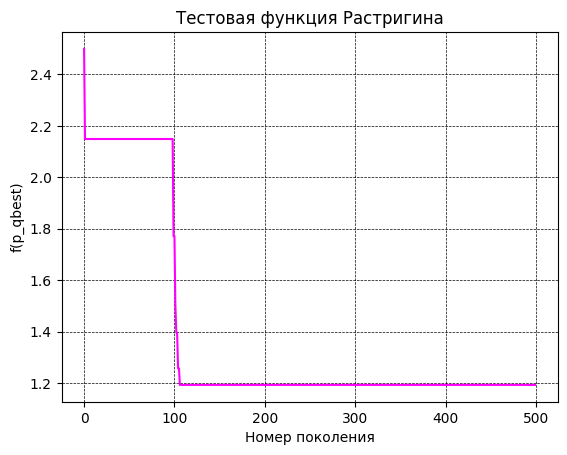

------------------------TEST NUMBER: 2------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.96331533 -0.93423942]
The function value of pqbest:		2.906786551859639
Algorithm running time:			0.15161538124084473 s


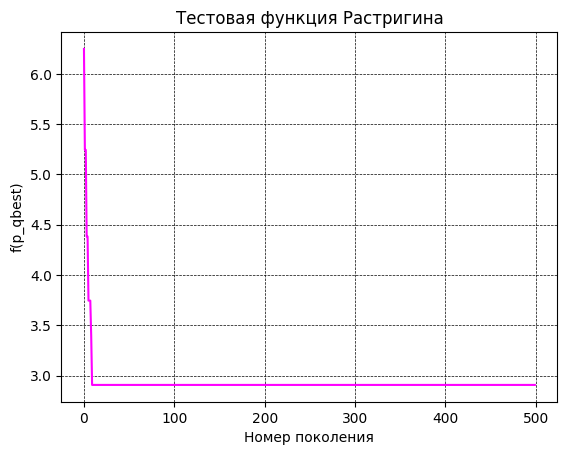

------------------------TEST NUMBER: 3------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.06283063 -1.93657216]
The function value of pqbest:		5.307105203722484
Algorithm running time:			0.10563945770263672 s


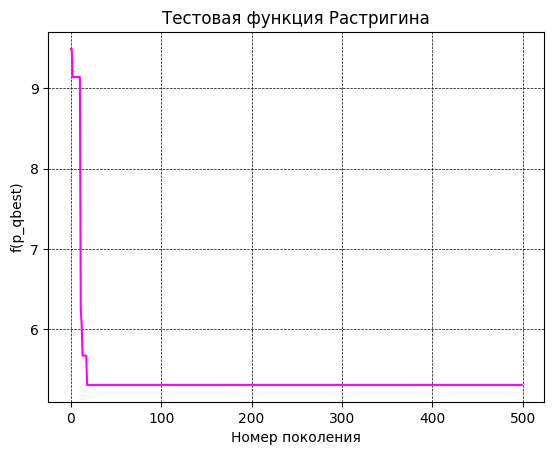

------------------------TEST NUMBER: 4------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.0065001  -0.00115919]
The function value of pqbest:		0.008647742505146994
Algorithm running time:			0.07199382781982422 s


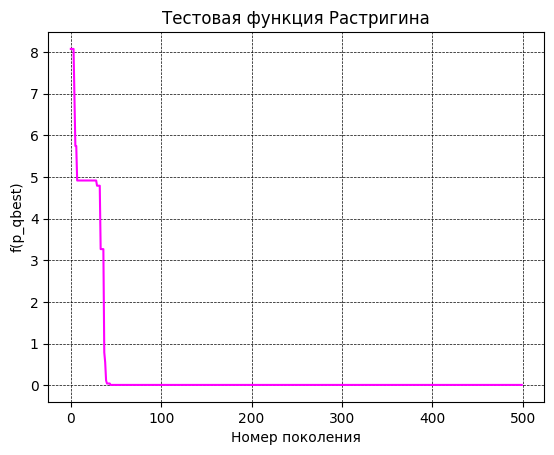

------------------------TEST NUMBER: 5------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.93210931  0.94978635]
The function value of pqbest:		3.1606099088030533
Algorithm running time:			0.048007965087890625 s


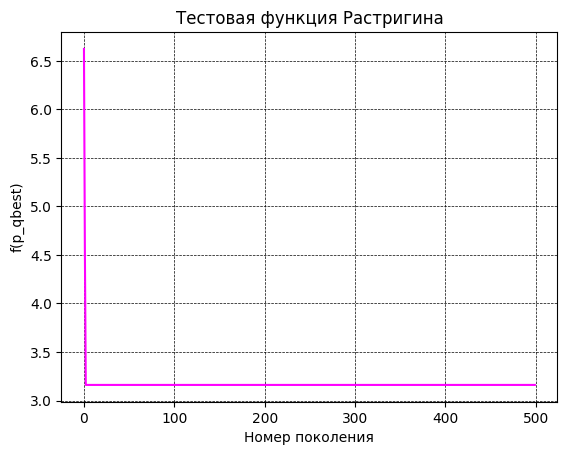

------------------------TEST NUMBER: 6------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[0.96563241 0.05063914]
The function value of pqbest:		1.669172683447698
Algorithm running time:			0.047821760177612305 s


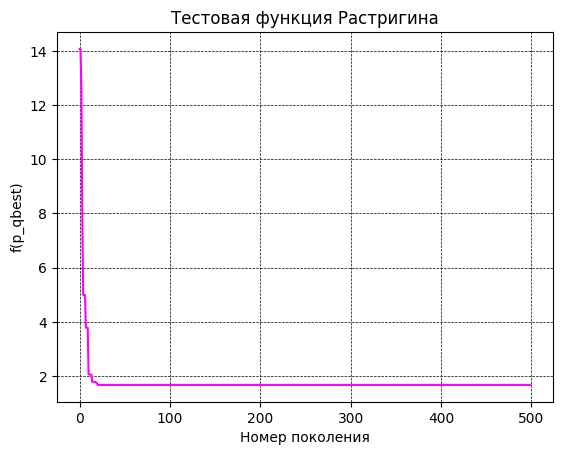

------------------------TEST NUMBER: 7------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.01627539  1.9760332 ]
The function value of pqbest:		4.070382841811053
Algorithm running time:			0.05276656150817871 s


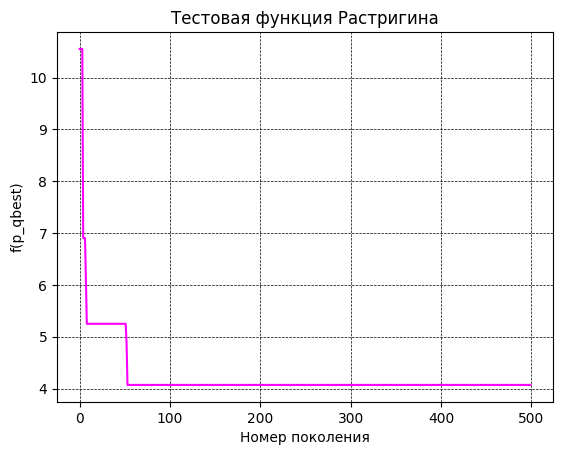

------------------------TEST NUMBER: 8------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-1.9714087  0.0030104]
The function value of pqbest:		4.049177279903226
Algorithm running time:			0.0651705265045166 s


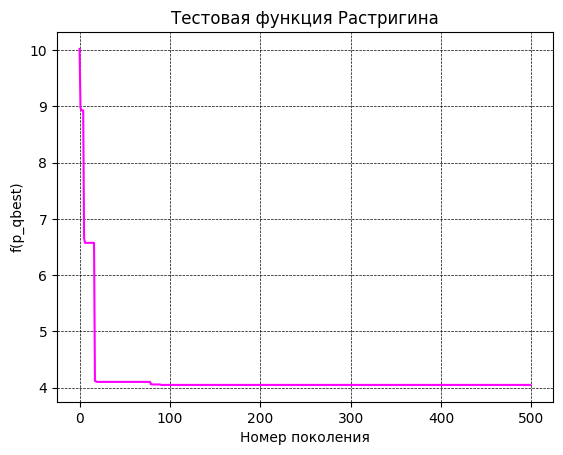

------------------------TEST NUMBER: 9------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[1.0151786 1.0283932]
The function value of pqbest:		2.2923335635582696
Algorithm running time:			0.047749996185302734 s


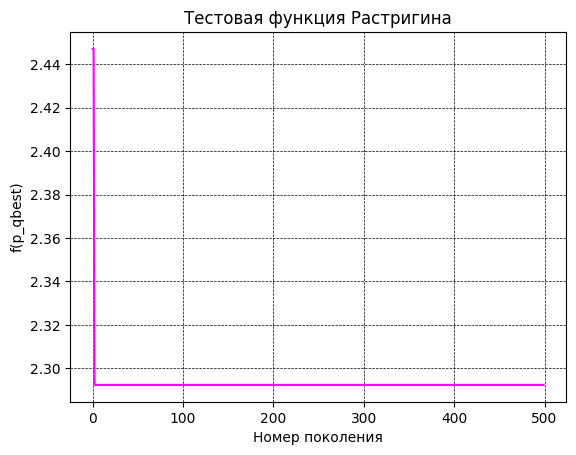

------------------------TEST NUMBER: 10------------------------
Theoretical value (Растригина): 0

Coordinates of p_qbest:			[-0.01986231  0.04392367]
The function value of pqbest:		0.4585115607739496
Algorithm running time:			0.04800987243652344 s


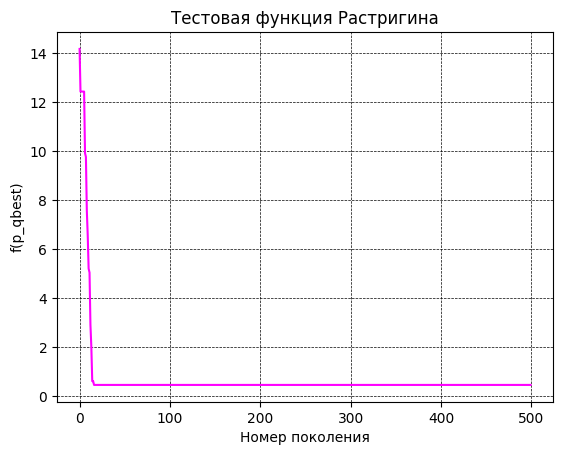

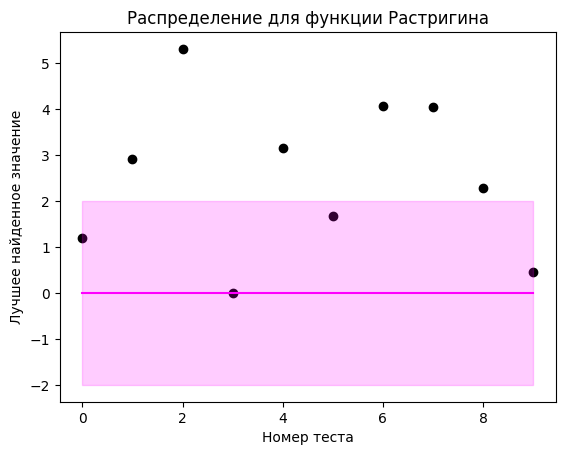

In [134]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [135]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [136]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.108619    0.17338034]
The function value of pqbest:		1.4306255619640567
Algorithm running time:			4.1998291015625 s


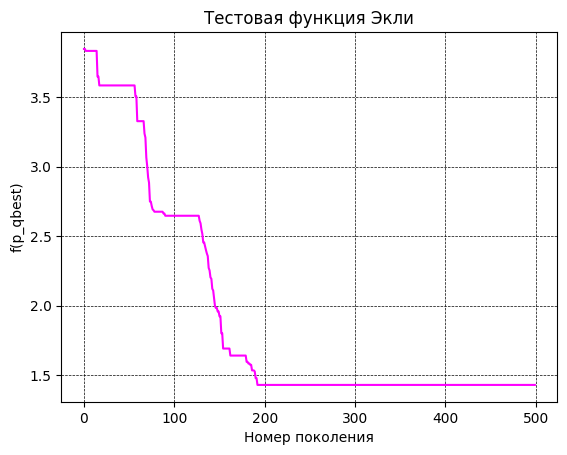

------------------------TEST NUMBER: 2------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.12421586 -0.2872074 ]
The function value of pqbest:		2.3134838789803247
Algorithm running time:			0.055993080139160156 s


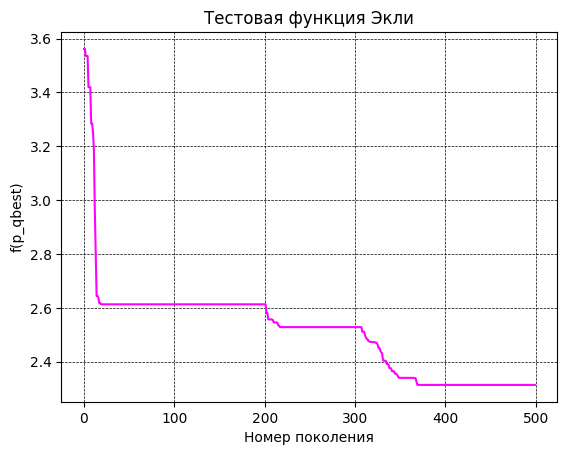

------------------------TEST NUMBER: 3------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.13494674  0.22271117]
The function value of pqbest:		1.9253959357568426
Algorithm running time:			0.04430866241455078 s


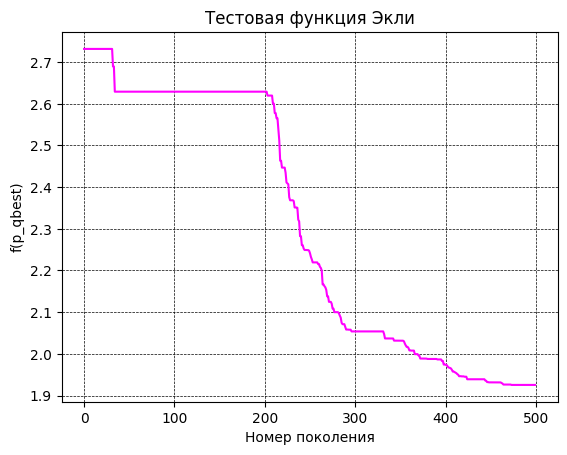

------------------------TEST NUMBER: 4------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.03947456  0.10762194]
The function value of pqbest:		0.6418030108312287
Algorithm running time:			0.04797840118408203 s


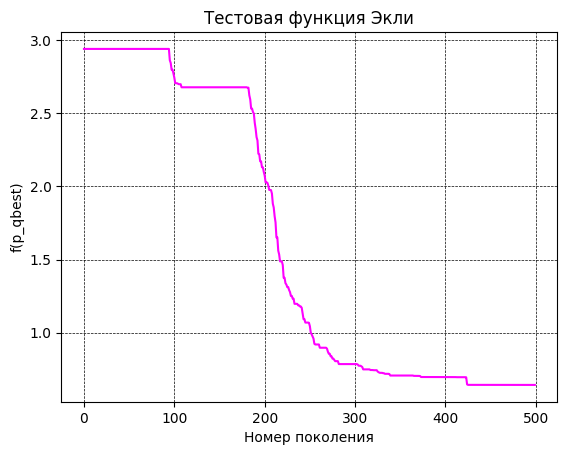

------------------------TEST NUMBER: 5------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.0246748   0.06049367]
The function value of pqbest:		0.2949115020497324
Algorithm running time:			0.05600118637084961 s


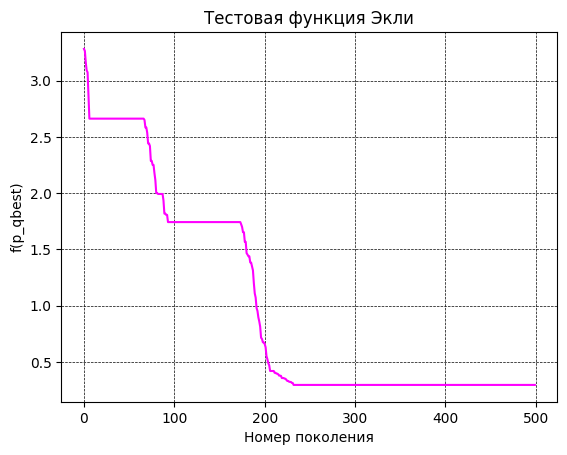

------------------------TEST NUMBER: 6------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[ 1.00746238 -0.00899828]
The function value of pqbest:		2.6596062505643623
Algorithm running time:			0.05600452423095703 s


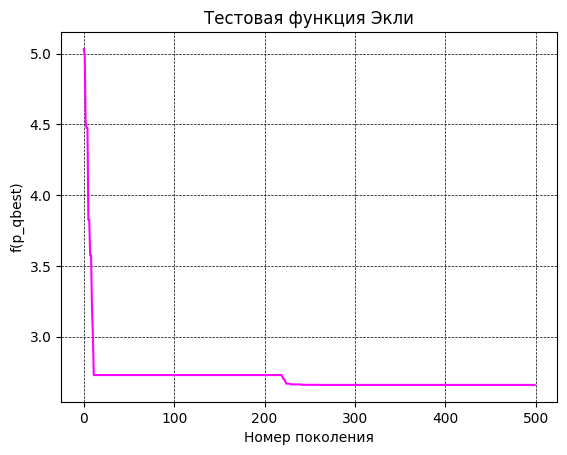

------------------------TEST NUMBER: 7------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.80952826 -0.06850628]
The function value of pqbest:		2.9981233350820027
Algorithm running time:			0.06208038330078125 s


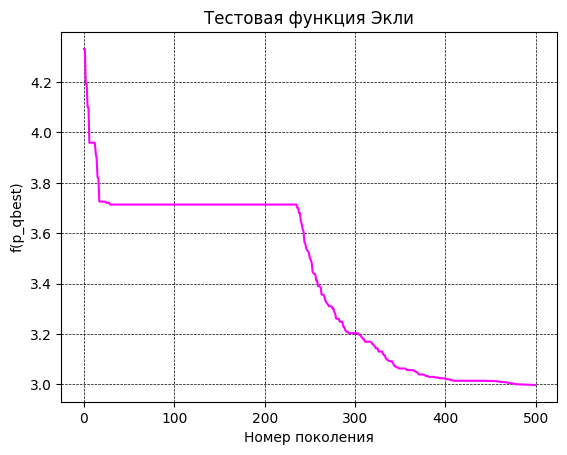

------------------------TEST NUMBER: 8------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.95372379  0.06182638]
The function value of pqbest:		2.6822729732799147
Algorithm running time:			0.05601048469543457 s


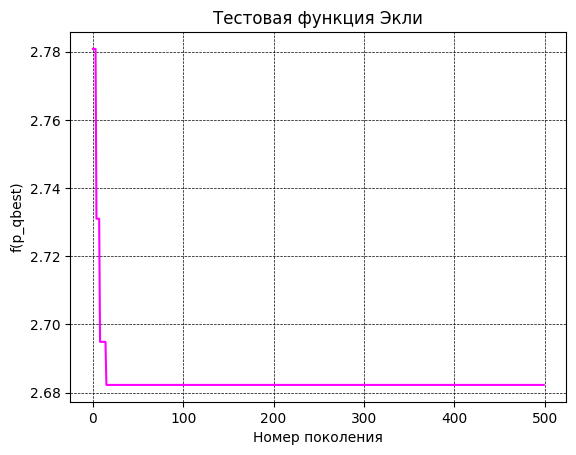

------------------------TEST NUMBER: 9------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.00280513  0.30106229]
The function value of pqbest:		2.143873897671778
Algorithm running time:			0.05602264404296875 s


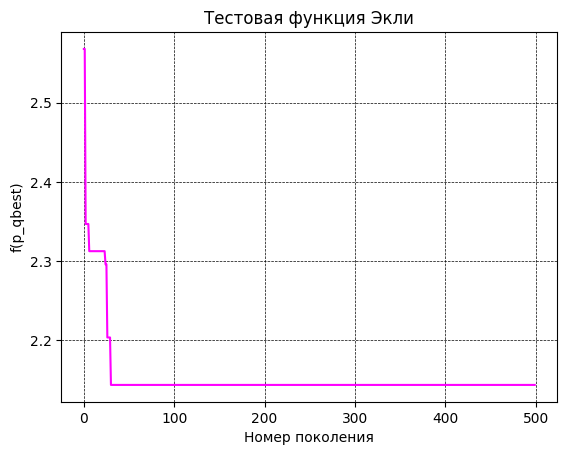

------------------------TEST NUMBER: 10------------------------
Theoretical value (Экли): 0

Coordinates of p_qbest:			[-0.08190815  0.14829088]
The function value of pqbest:		1.1094869736765993
Algorithm running time:			0.04817366600036621 s


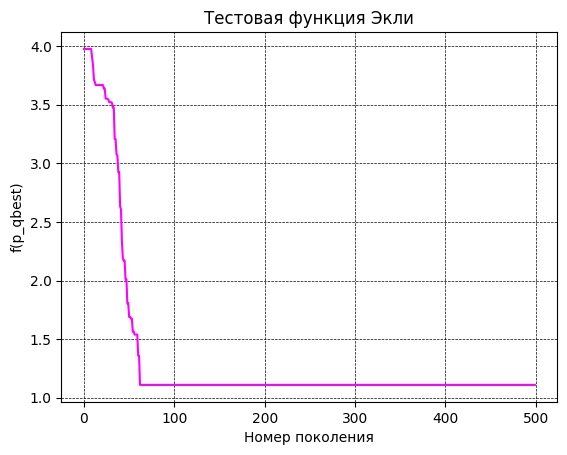

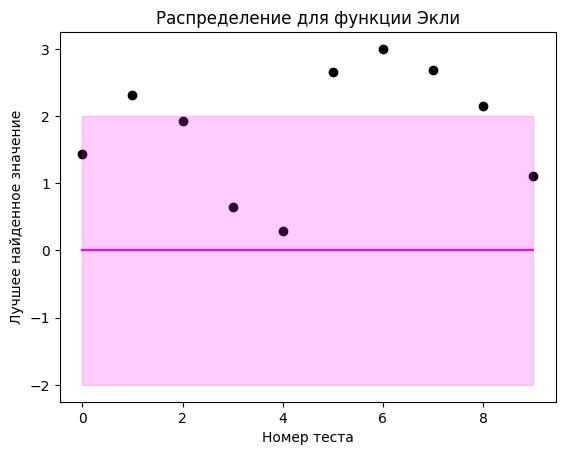

In [137]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [138]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [139]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-1, 1, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[-0.00221775  0.00205812]
The function value of pqbest:		9.154283268316109e-06
Algorithm running time:			3.5685696601867676 s


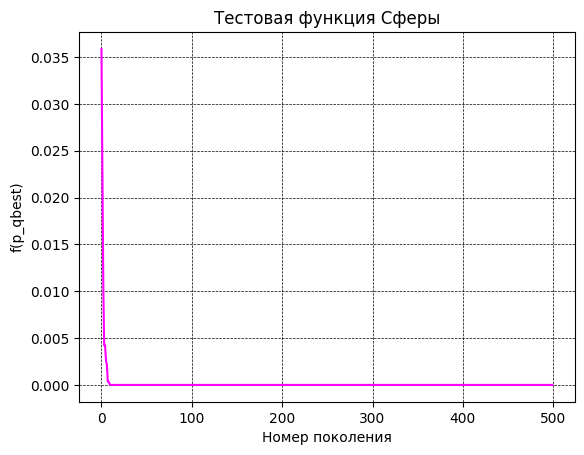

------------------------TEST NUMBER: 2------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[-0.00681736 -0.0028793 ]
The function value of pqbest:		5.4766811791713614e-05
Algorithm running time:			0.04799652099609375 s


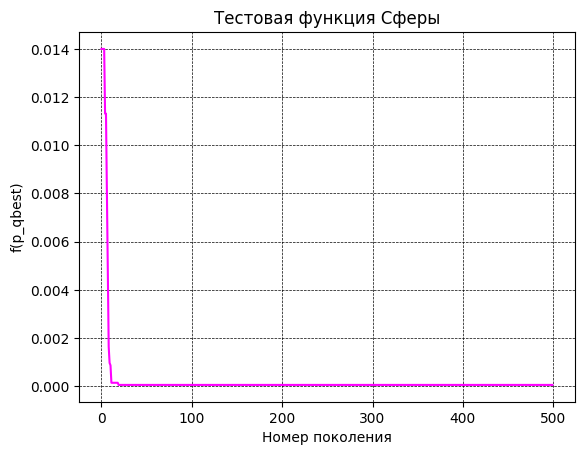

------------------------TEST NUMBER: 3------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[0.00290678 0.00774389]
The function value of pqbest:		6.841720745446378e-05
Algorithm running time:			0.06400227546691895 s


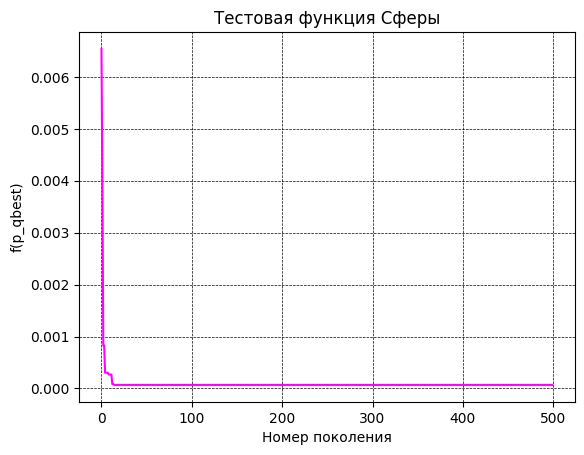

------------------------TEST NUMBER: 4------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[ 0.00747105 -0.00068593]
The function value of pqbest:		5.628707548533429e-05
Algorithm running time:			0.03999614715576172 s


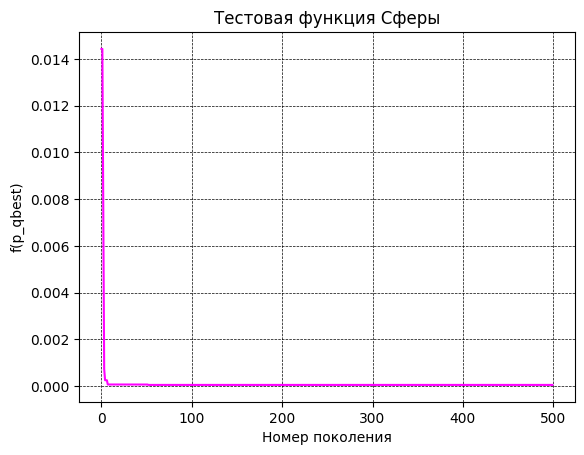

------------------------TEST NUMBER: 5------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[0.00616529 0.00503633]
The function value of pqbest:		6.337542023904535e-05
Algorithm running time:			0.04039740562438965 s


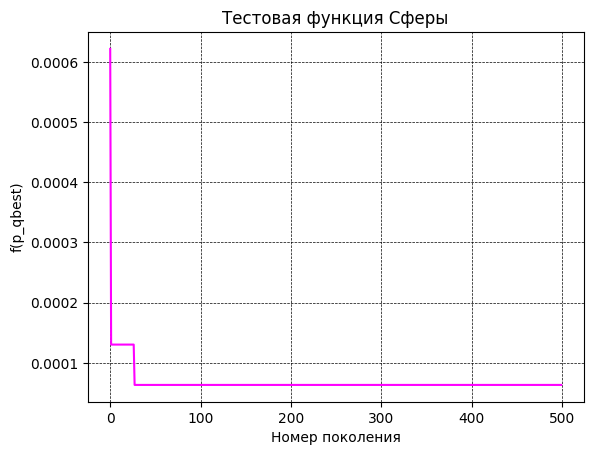

------------------------TEST NUMBER: 6------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[0.0033749  0.00188793]
The function value of pqbest:		1.4954235762154319e-05
Algorithm running time:			0.0479888916015625 s


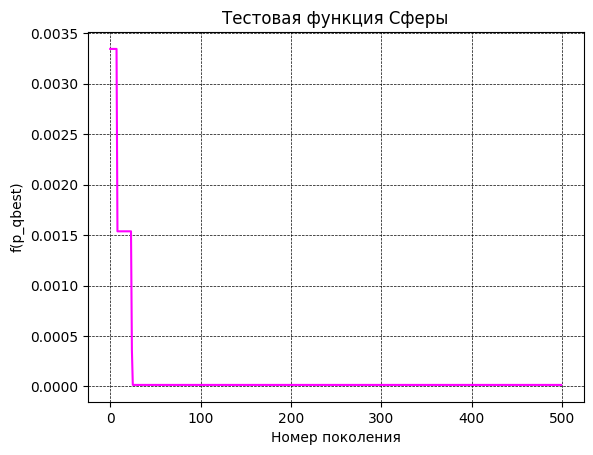

------------------------TEST NUMBER: 7------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[0.00134148 0.00909787]
The function value of pqbest:		8.457085232745036e-05
Algorithm running time:			0.040514230728149414 s


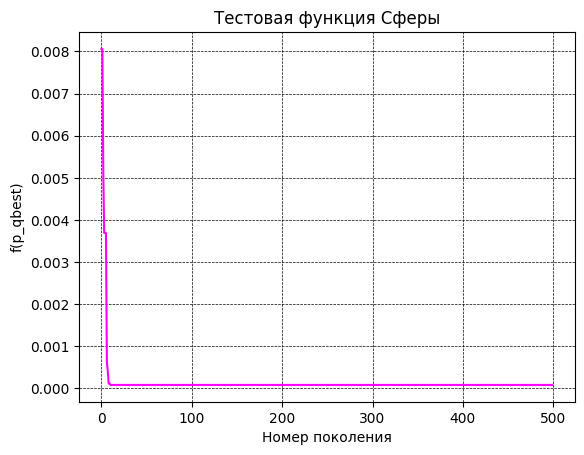

------------------------TEST NUMBER: 8------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[ 0.01775707 -0.00139938]
The function value of pqbest:		0.00031727186987423806
Algorithm running time:			0.04046273231506348 s


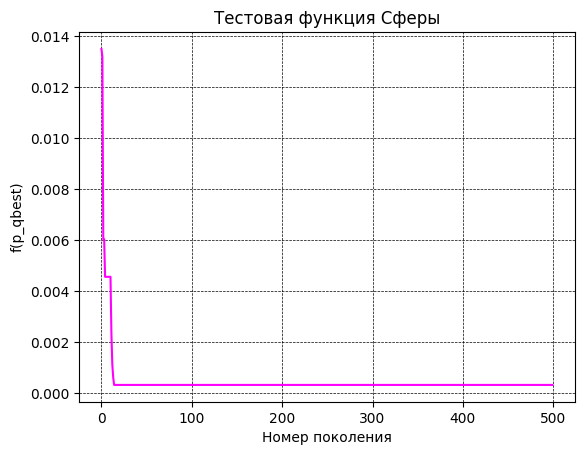

------------------------TEST NUMBER: 9------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[-0.00258732  0.00772673]
The function value of pqbest:		6.639654704384144e-05
Algorithm running time:			0.04001808166503906 s


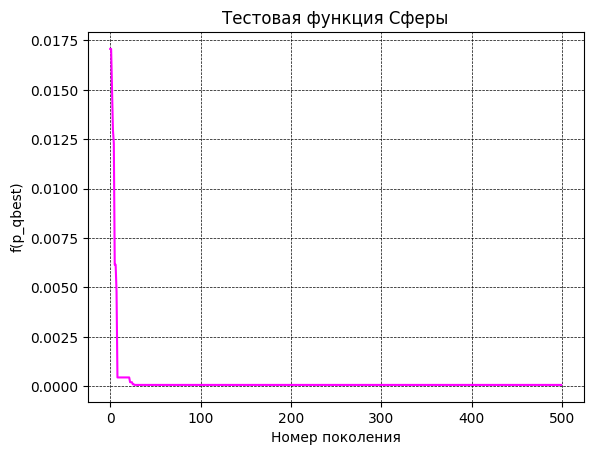

------------------------TEST NUMBER: 10------------------------
Theoretical value (Сферы): 0

Coordinates of p_qbest:			[-0.00468879  0.00381135]
The function value of pqbest:		3.651114780879682e-05
Algorithm running time:			0.04020524024963379 s


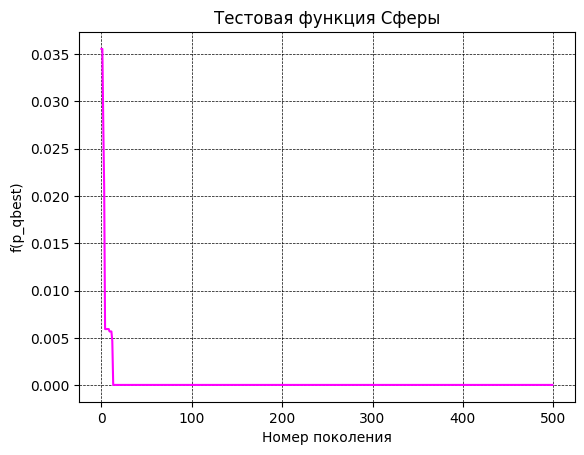

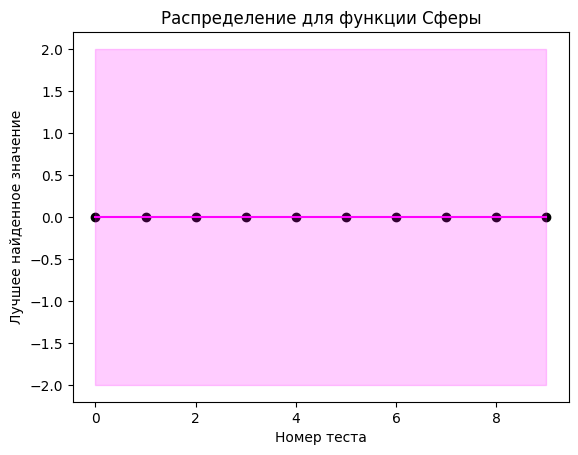

In [140]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [141]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [142]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[1.50170933 2.25857855]
The function value of pqbest:		0.2529008762317094
Algorithm running time:			3.443197250366211 s


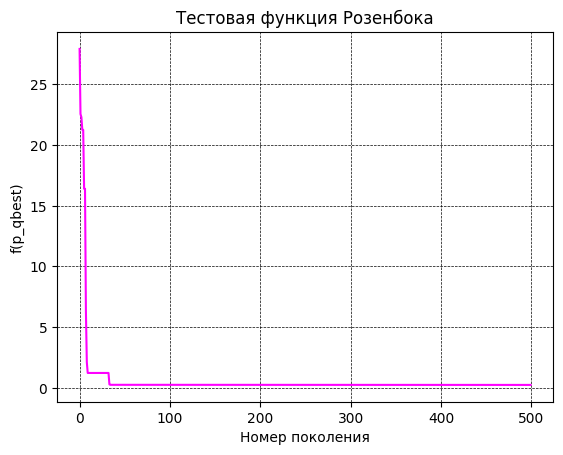

------------------------TEST NUMBER: 2------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[1.75514442 3.08247318]
The function value of pqbest:		0.5706199374048748
Algorithm running time:			0.03998517990112305 s


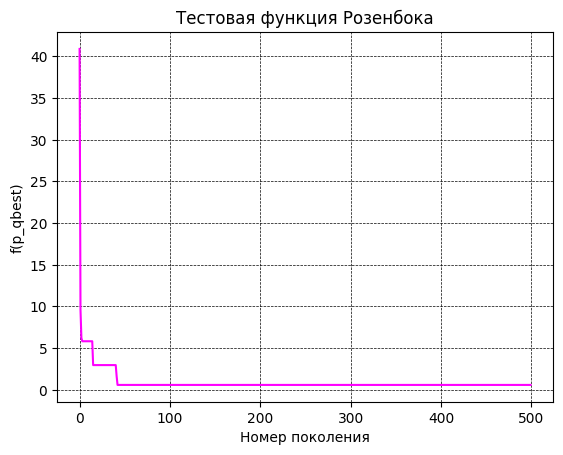

------------------------TEST NUMBER: 3------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[2.78073219 7.59953583]
The function value of pqbest:		4.938197415341784
Algorithm running time:			0.032011985778808594 s


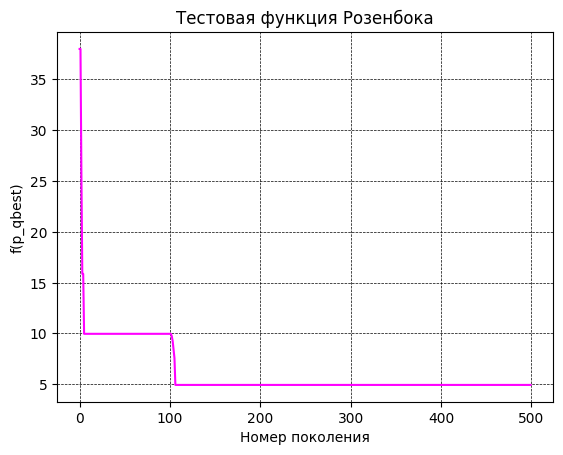

------------------------TEST NUMBER: 4------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[2.62539061 6.93040052]
The function value of pqbest:		2.784209601086954
Algorithm running time:			0.08912968635559082 s


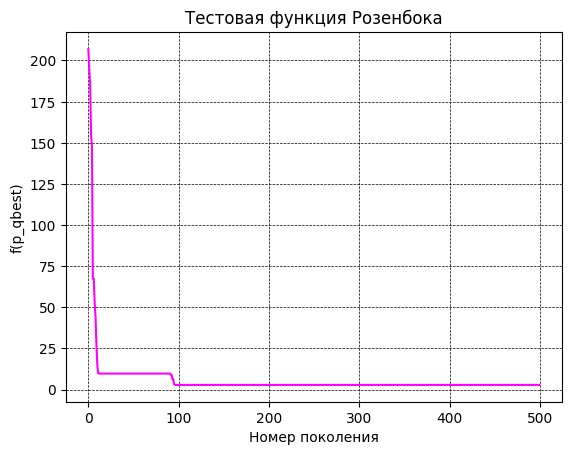

------------------------TEST NUMBER: 5------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[1.47646375 2.37334092]
The function value of pqbest:		3.96720819066634
Algorithm running time:			0.04799985885620117 s


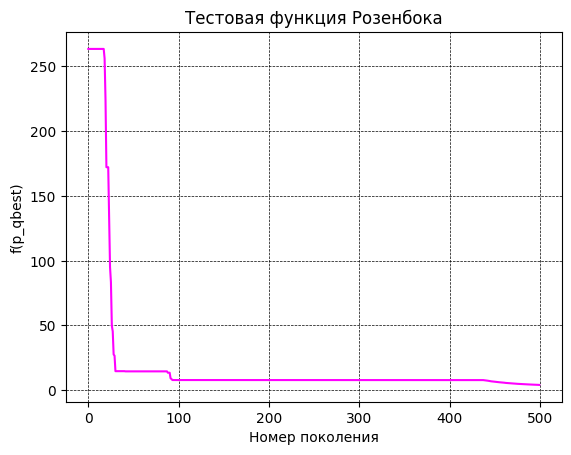

------------------------TEST NUMBER: 6------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[2.16531046 4.67163423]
The function value of pqbest:		1.3866284122396122
Algorithm running time:			0.04001975059509277 s


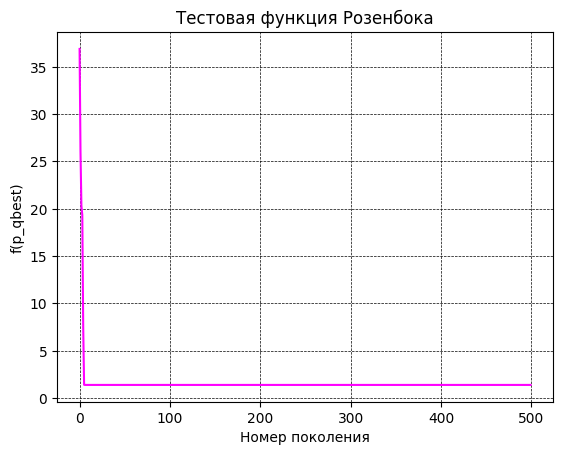

------------------------TEST NUMBER: 7------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[2.298425   5.28501972]
The function value of pqbest:		1.6864192554391908
Algorithm running time:			0.040013790130615234 s


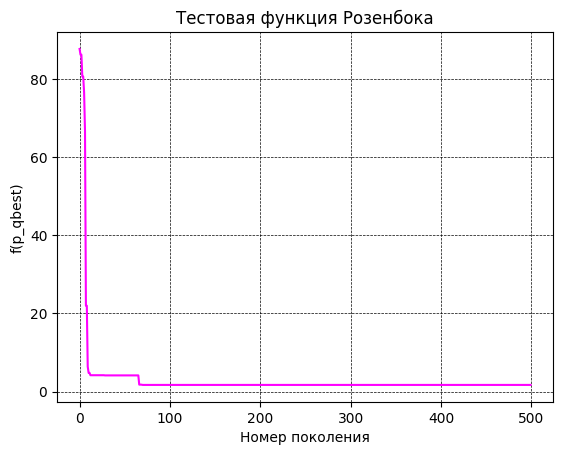

------------------------TEST NUMBER: 8------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[-1.45676792  2.1247894 ]
The function value of pqbest:		6.036393284010941
Algorithm running time:			0.03998827934265137 s


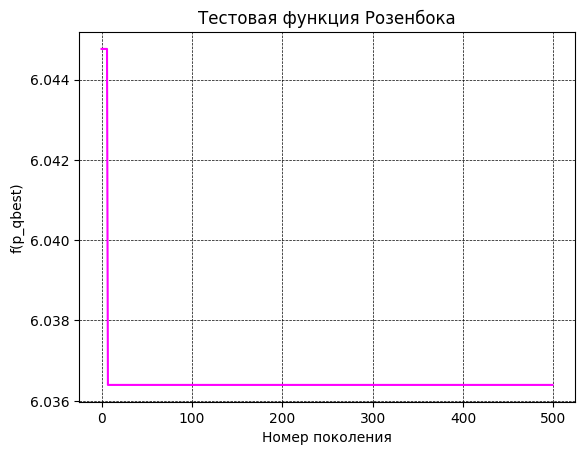

------------------------TEST NUMBER: 9------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[-1.14753265  1.32065049]
The function value of pqbest:		4.613355206178178
Algorithm running time:			0.04799914360046387 s


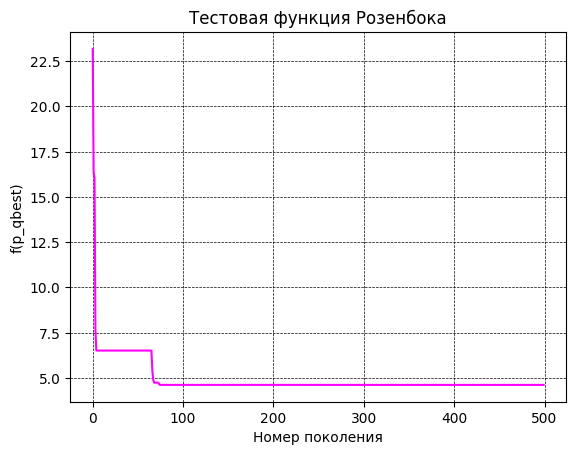

------------------------TEST NUMBER: 10------------------------
Theoretical value (Розенбока): 0

Coordinates of p_qbest:			[-0.342062    0.18050762]
The function value of pqbest:		2.2043708153999932
Algorithm running time:			0.04808831214904785 s


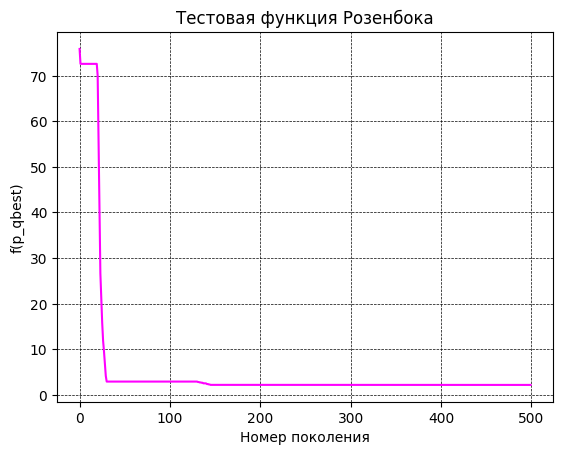

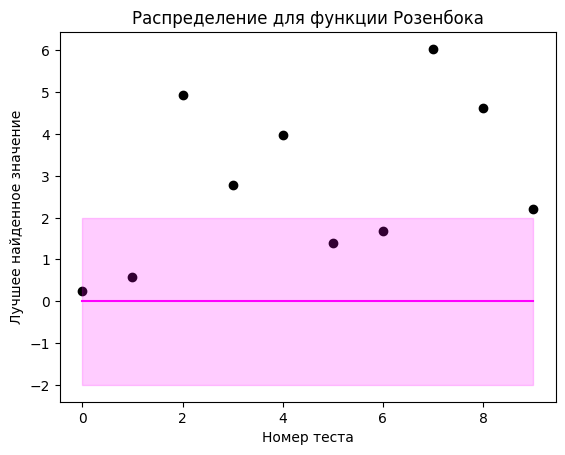

In [143]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [144]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [145]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[3.16122235 0.53990896]
The function value of pqbest:		0.003677789371204096
Algorithm running time:			3.384859085083008 s


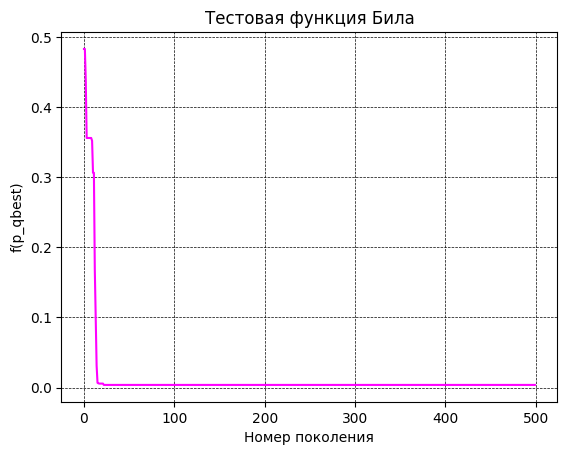

------------------------TEST NUMBER: 2------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[3.94997188 0.66342886]
The function value of pqbest:		0.060014896665865125
Algorithm running time:			0.040015220642089844 s


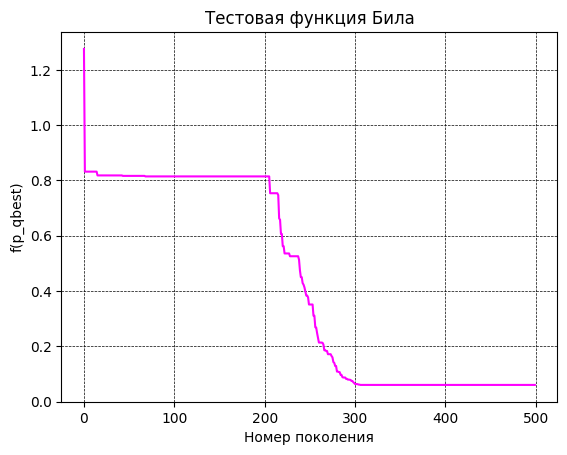

------------------------TEST NUMBER: 3------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[2.86328261 0.46854171]
The function value of pqbest:		0.003867773368758867
Algorithm running time:			0.03999137878417969 s


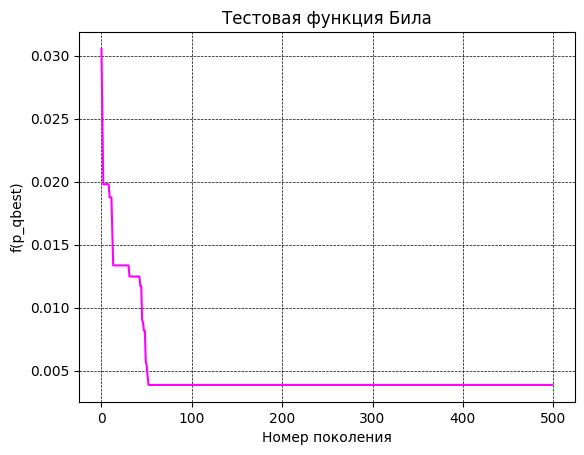

------------------------TEST NUMBER: 4------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[2.63665002 0.4096285 ]
The function value of pqbest:		0.03507033667586015
Algorithm running time:			0.0400087833404541 s


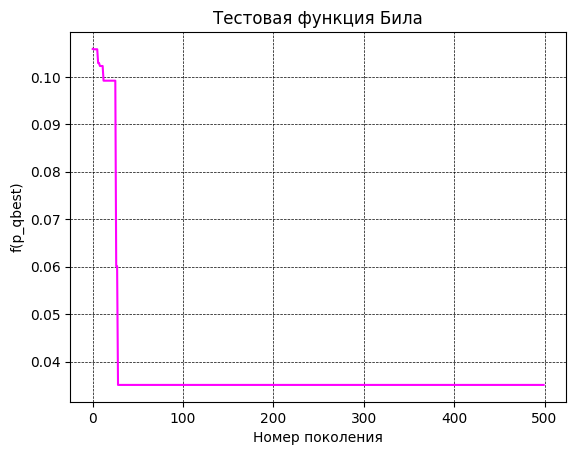

------------------------TEST NUMBER: 5------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[5.13770716 0.7582014 ]
The function value of pqbest:		0.1454653003156005
Algorithm running time:			0.04000687599182129 s


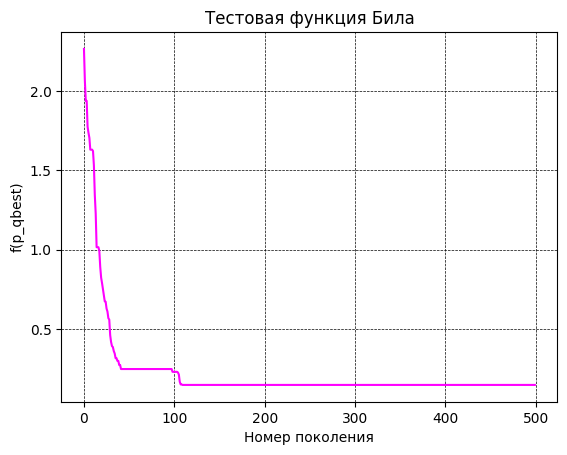

------------------------TEST NUMBER: 6------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[4.40842781 0.71487815]
The function value of pqbest:		0.09788892092637336
Algorithm running time:			0.04002499580383301 s


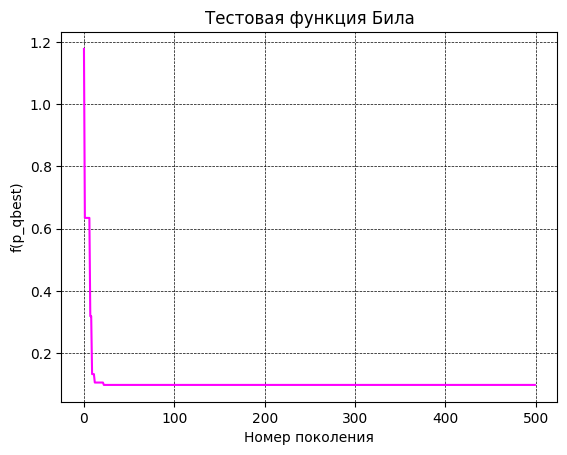

------------------------TEST NUMBER: 7------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[4.51368248 0.71627628]
The function value of pqbest:		0.10371401814911357
Algorithm running time:			0.03999662399291992 s


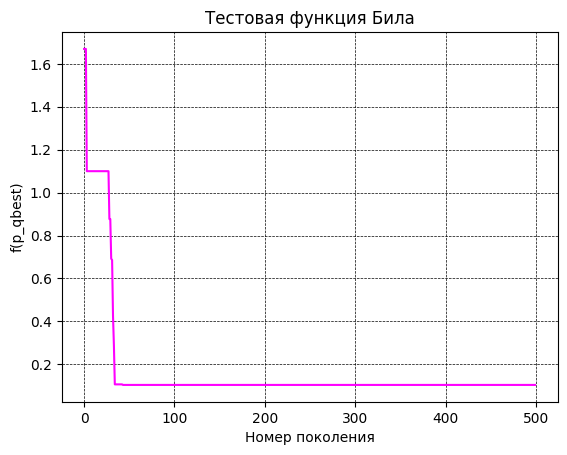

------------------------TEST NUMBER: 8------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[3.78632313 0.643695  ]
The function value of pqbest:		0.046775513213702116
Algorithm running time:			0.03974175453186035 s


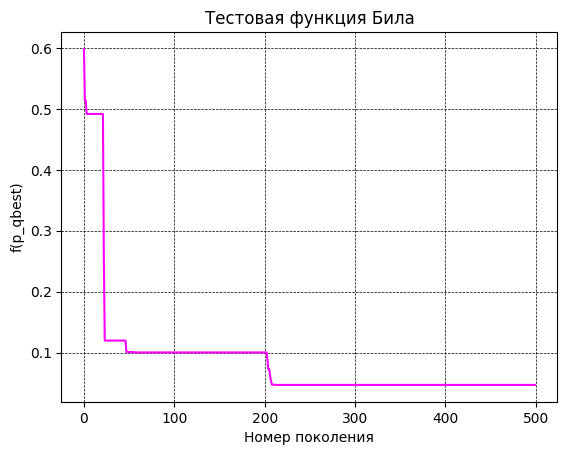

------------------------TEST NUMBER: 9------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[2.62555924 0.39578747]
The function value of pqbest:		0.03505718132531133
Algorithm running time:			0.040009260177612305 s


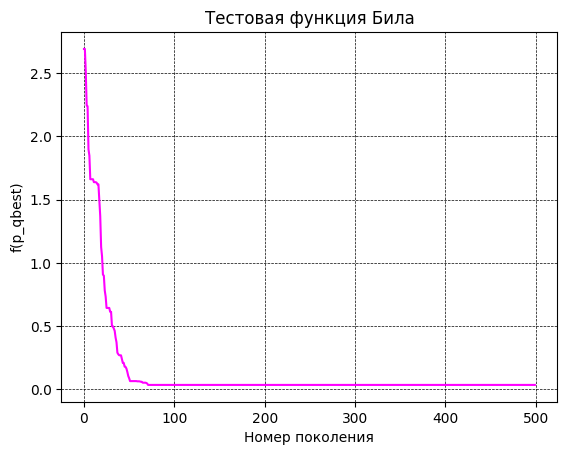

------------------------TEST NUMBER: 10------------------------
Theoretical value (Била): 0

Coordinates of p_qbest:			[2.98133937 0.49642872]
The function value of pqbest:		8.375358709038421e-05
Algorithm running time:			0.07997870445251465 s


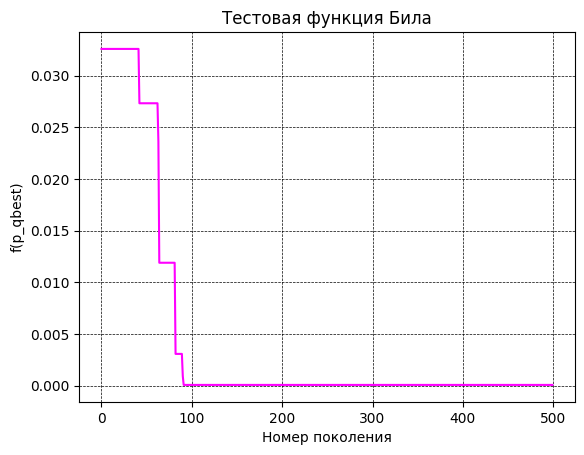

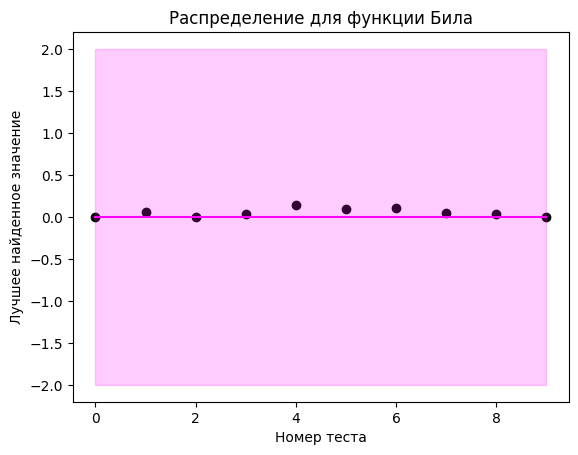

In [146]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [147]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [148]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[-0.00161403 -1.00186384]
The function value of pqbest:		3.001510290181631
Algorithm running time:			3.975839138031006 s


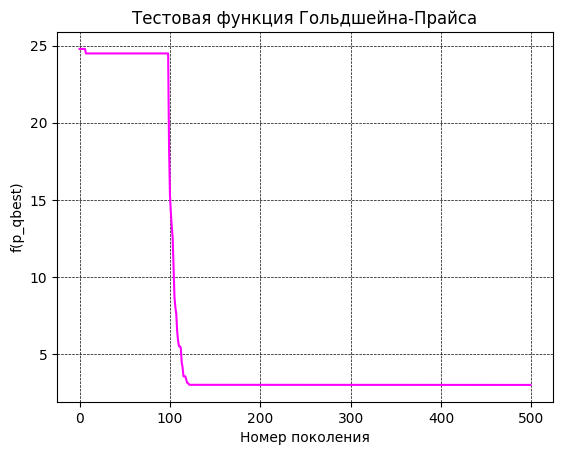

------------------------TEST NUMBER: 2------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[-0.00284828 -1.00311204]
The function value of pqbest:		3.0043279104418654
Algorithm running time:			0.048026323318481445 s


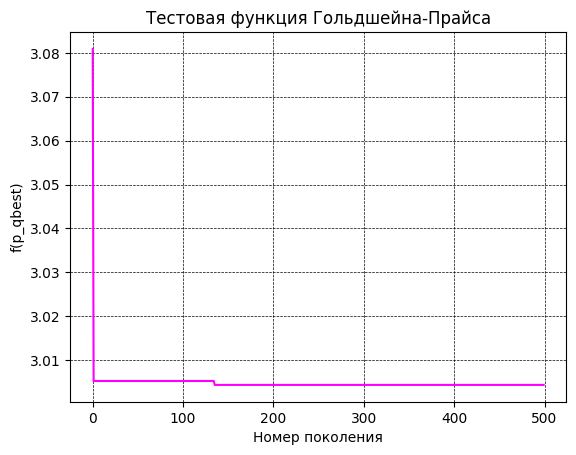

------------------------TEST NUMBER: 3------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.00296553 -0.9899507 ]
The function value of pqbest:		3.039117170897557
Algorithm running time:			0.06400442123413086 s


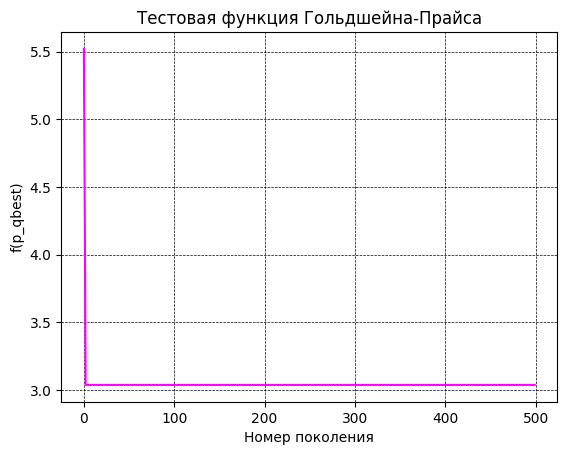

------------------------TEST NUMBER: 4------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[-0.05601948 -0.99633758]
The function value of pqbest:		3.864692333988352
Algorithm running time:			0.040026187896728516 s


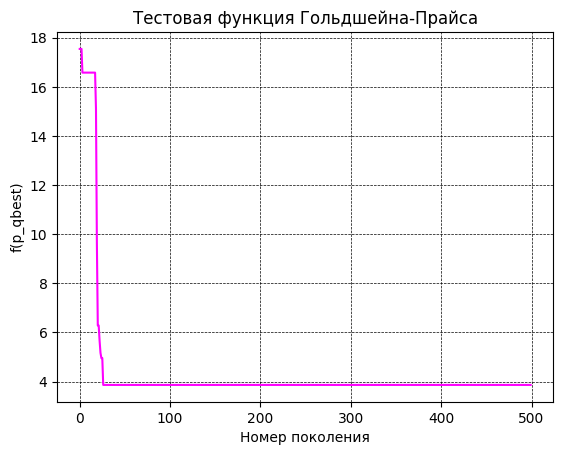

------------------------TEST NUMBER: 5------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[-0.00363317 -0.99896253]
The function value of pqbest:		3.0045851950730746
Algorithm running time:			0.03997659683227539 s


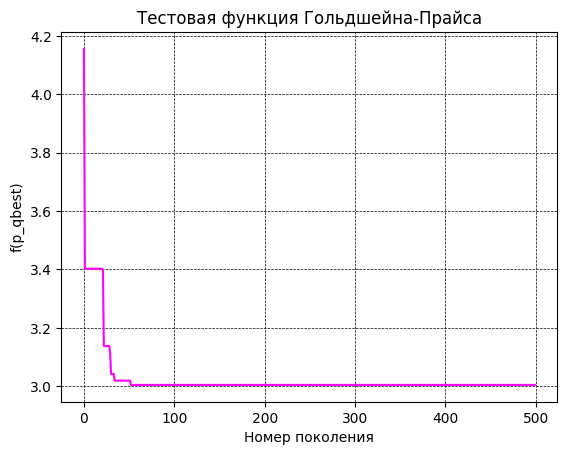

------------------------TEST NUMBER: 6------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.04056779 -0.94793043]
The function value of pqbest:		4.1313611537457975
Algorithm running time:			0.04000353813171387 s


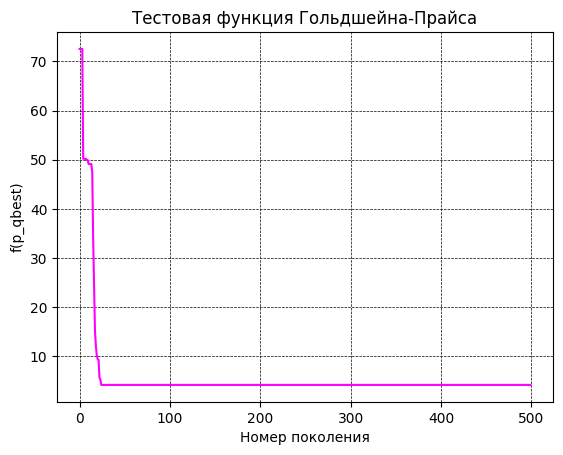

------------------------TEST NUMBER: 7------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.03983843 -0.96939488]
The function value of pqbest:		3.5213491596610664
Algorithm running time:			0.04025983810424805 s


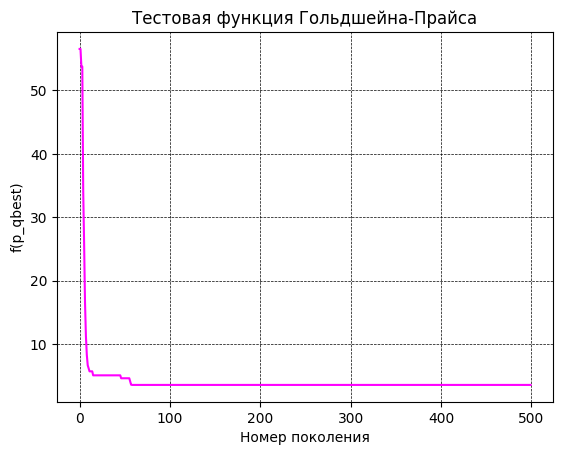

------------------------TEST NUMBER: 8------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.01154333 -0.97854092]
The function value of pqbest:		3.1777695292779824
Algorithm running time:			0.040015220642089844 s


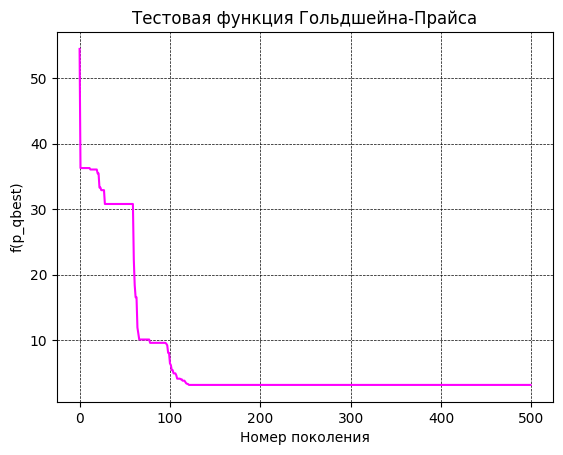

------------------------TEST NUMBER: 9------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.02241878 -1.05542949]
The function value of pqbest:		4.9905727938742235
Algorithm running time:			0.040007591247558594 s


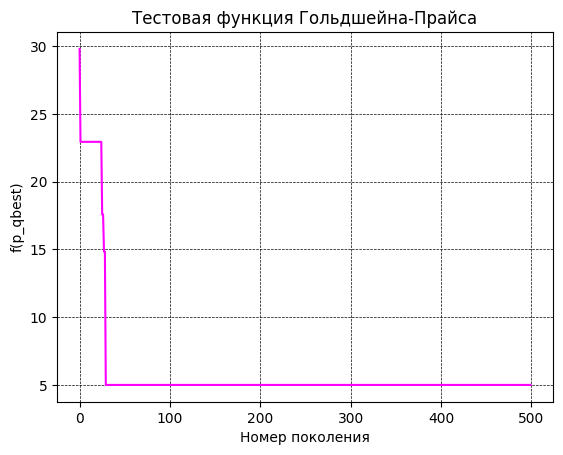

------------------------TEST NUMBER: 10------------------------
Theoretical value (Гольдшейна-Прайса): 3

Coordinates of p_qbest:			[ 0.02053354 -0.99151719]
The function value of pqbest:		3.098593527920531
Algorithm running time:			0.039086103439331055 s


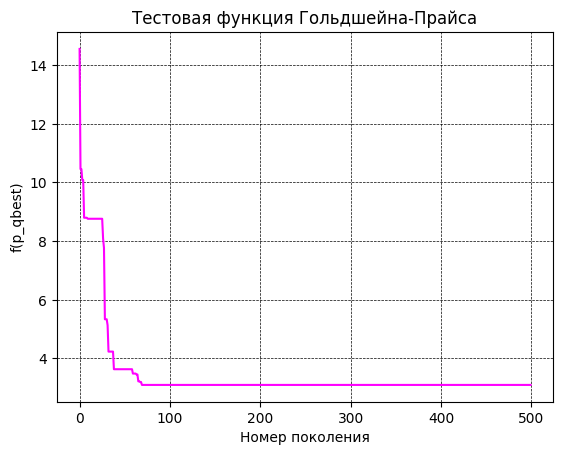

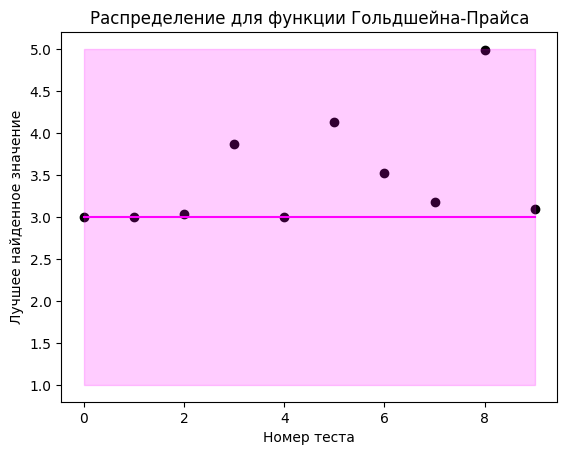

In [149]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3)

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [150]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [151]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.93817186 1.75212351]
The function value of pqbest:		0.43830457673202555
Algorithm running time:			3.4426567554473877 s


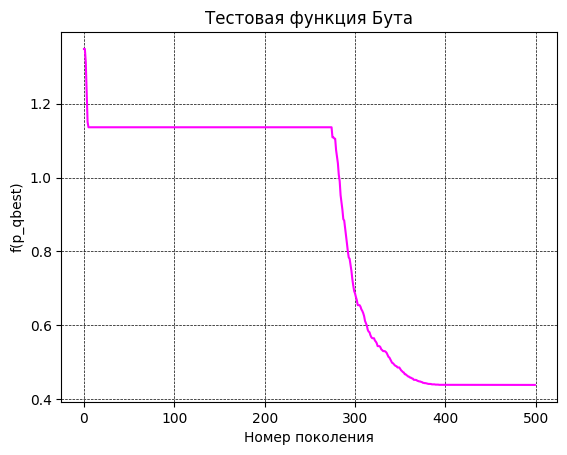

------------------------TEST NUMBER: 2------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.27867349 2.69551709]
The function value of pqbest:		0.07530966377647172
Algorithm running time:			0.03999924659729004 s


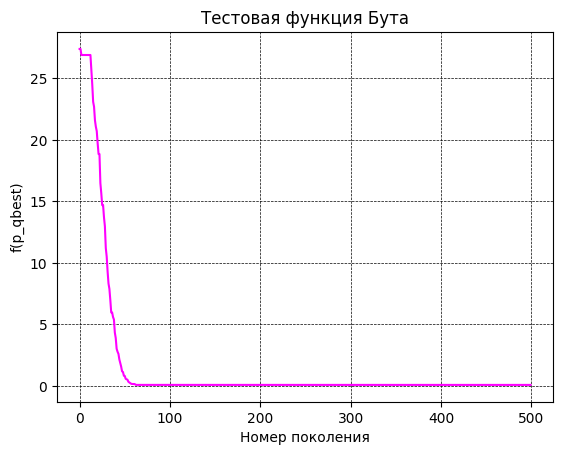

------------------------TEST NUMBER: 3------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.33518938 2.60790315]
The function value of pqbest:		0.07873040871865543
Algorithm running time:			0.04799151420593262 s


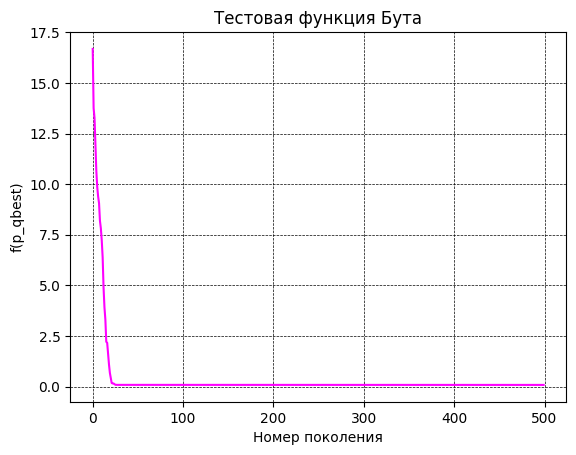

------------------------TEST NUMBER: 4------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.20305445 2.86659697]
The function value of pqbest:		0.0849066470177652
Algorithm running time:			0.03998231887817383 s


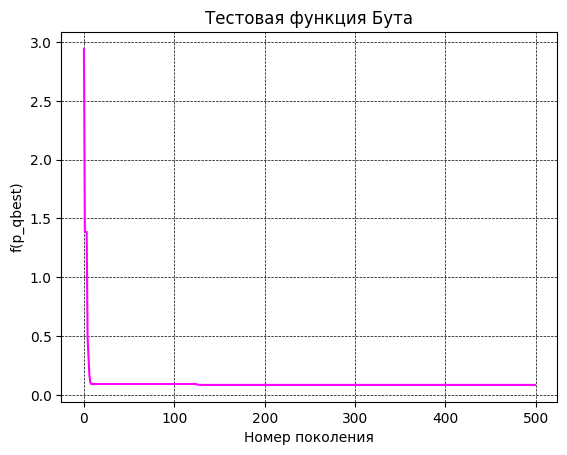

------------------------TEST NUMBER: 5------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[0.70562654 3.33405504]
The function value of pqbest:		5.330995772310054
Algorithm running time:			0.03982400894165039 s


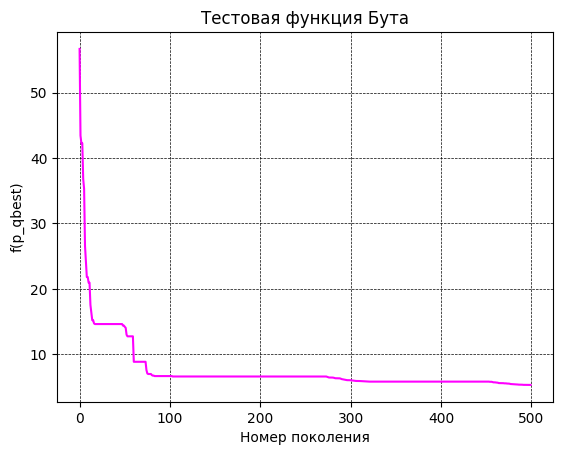

------------------------TEST NUMBER: 6------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.08743211 3.31329311]
The function value of pqbest:		0.28071819235448886
Algorithm running time:			0.04798102378845215 s


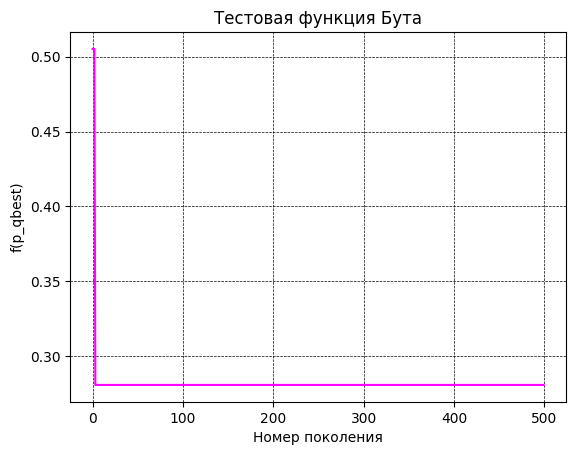

------------------------TEST NUMBER: 7------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[0.86036537 3.9586168 ]
The function value of pqbest:		0.4969648413232133
Algorithm running time:			0.040024518966674805 s


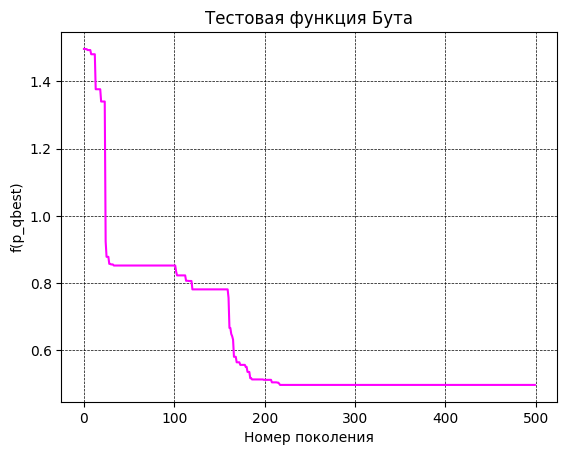

------------------------TEST NUMBER: 8------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[0.6981338  4.75386086]
The function value of pqbest:		1.4540843700028583
Algorithm running time:			0.04957127571105957 s


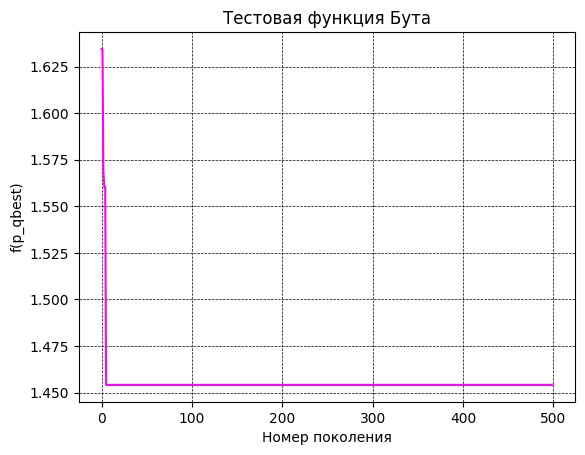

------------------------TEST NUMBER: 9------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.29356504 2.67096958]
The function value of pqbest:		0.07468922164902059
Algorithm running time:			0.048020124435424805 s


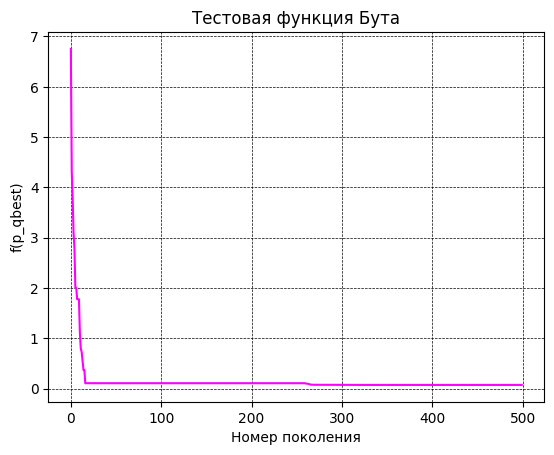

------------------------TEST NUMBER: 10------------------------
Theoretical value (Бута): 0

Coordinates of p_qbest:			[1.15198809 2.99408516]
The function value of pqbest:		0.09918327185860776
Algorithm running time:			0.03999662399291992 s


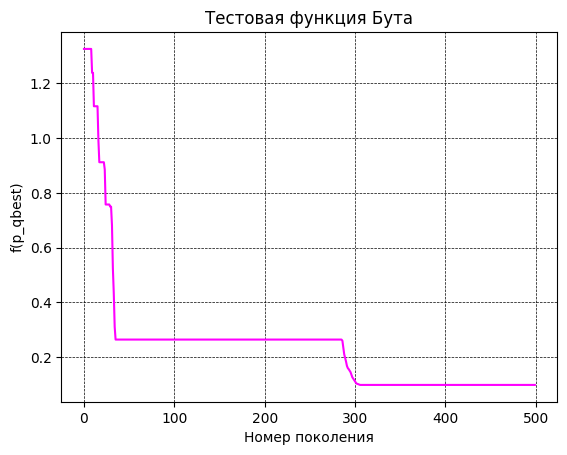

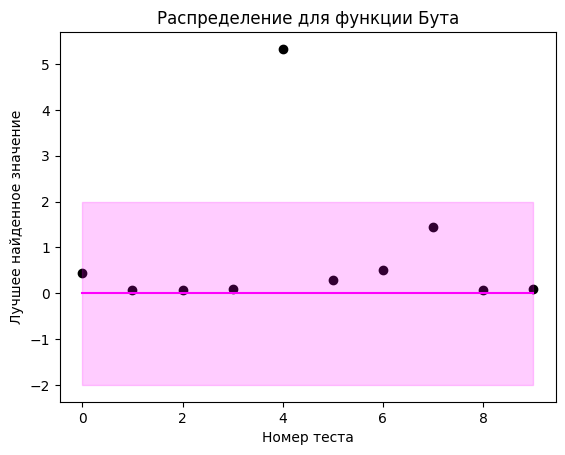

In [152]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_)

## Реализация алгоритма на C. Сравнение двух реализаций

In [153]:
import ctypes
import os


class Result(ctypes.Structure):
    _fields_ = [
        ("best_solution", ctypes.POINTER(ctypes.c_float)),
        ("best_y", ctypes.c_float),
        ("time_spent", ctypes.c_double)
    ]


def c(file, name, types, result):
    path = os.path.abspath(file)
    module = ctypes.cdll.LoadLibrary(path)
    func = module[name]
    func.argtypes = types
    func.restype = result
    return func


test_Rastrigen = c("libcode.dll", "test_Rastrigen", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Ekli = c("libcode.dll", "test_Ekli", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Sphere = c("libcode.dll", "test_Sphere", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Rosenbock = c("libcode.dll", "test_Rosenbock", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Bila = c("libcode.dll", "test_Bila", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Goldsheina_Praisa = c("libcode.dll", "test_Goldsheina_Praisa", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)
test_Buta = c("libcode.dll", "test_Buta", (ctypes.c_int, ctypes.c_int, ctypes.c_int), Result)


## Сравнение реализаций по скорости выполнения

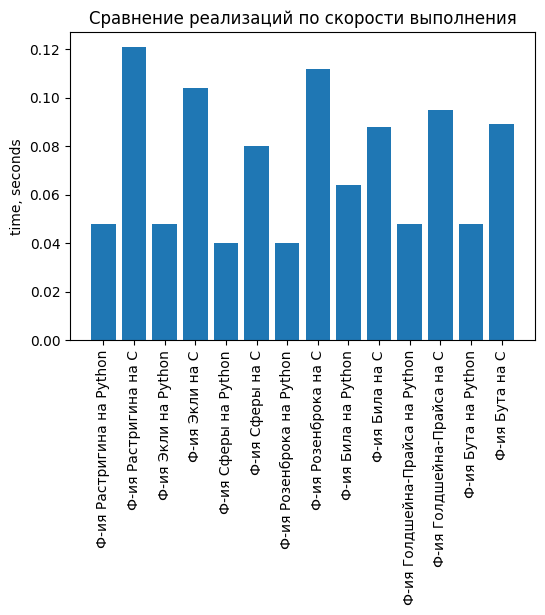

In [154]:
time_on_c = list()
time_on_c.append(test_Rastrigen(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Ekli(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Sphere(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Rosenbock(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Bila(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Goldsheina_Praisa(number_of_agents_, n_args_count_, iter_max_).time_spent)
time_on_c.append(test_Buta(number_of_agents_, n_args_count_, iter_max_).time_spent)

time_on_python = list()
start = time.time()
main_function(f1, generate_agents1, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f2, generate_agents2, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f3, generate_agents3, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f4, generate_agents4, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f5, generate_agents5, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f6, generate_agents6, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)
start = time.time()
main_function(f7, generate_agents7, n_args_count_, iter_max_, number_of_agents_, max_weight_)
end = time.time() - start
time_on_python.append(end)

plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

list_to_draw = list()
for i in range(7):
    list_to_draw.append(time_on_python[i])
    list_to_draw.append(time_on_c[i])

list_of_title = ['Ф-ия Растригина на Python', 'Ф-ия Растригина на C',
                 'Ф-ия Экли на Python', 'Ф-ия Экли на C',
                 'Ф-ия Сферы на Python', 'Ф-ия Сферы на C',
                 'Ф-ия Розенброка на Python', 'Ф-ия Розенброка на С',
                 'Ф-ия Била на Python', 'Ф-ия Била на C',
                 'Ф-ия Голдшейна-Прайса на Python', 'Ф-ия Голдшейна-Прайса на C',
                 'Ф-ия Бута на Python', 'Ф-ия Бута на C']

ax.bar(list_of_title, list_to_draw)

plt.ylabel("time, seconds")
plt.title("Сравнение реализаций по скорости выполнения")
plt.xticks(rotation=90)
plt.show()

## Тестирование алгоритма в n-мерном пространстве

### Тестирование алгоритма в 100-мерном пространстве

In [97]:
start = time.time()
res = main_function(f3, generate_agents3, 100, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 7.83839999808262
Time is 8.546939849853516
Coordinates: [-0.01461523  0.40158649  0.29920827  0.30797507  0.34206651 -0.04727888
  0.09802692  0.19218935  0.07653566  0.23741665  0.35784918  0.3228778
  0.27096489  0.270692    0.25549173  0.27041753  0.35627098  0.36671147
  0.27289764  0.2192784   0.45376702  0.28108338  0.31843085  0.31257644
  0.0883634   0.30700201  0.13706985  0.29467947  0.23952454  0.21272725
  0.31801226  0.29503359  0.26212068  0.23302186  0.36577441  0.32642406
 -0.13128564  0.33567763  0.30697849  0.26504323  0.28867557  0.30999928
  0.28652184  0.27279779  0.22347787  0.19455194  0.29695399  0.24264899
  0.28002313 -0.14555896  0.22976996  0.28262078  0.25661435  0.23432025
  0.22668165  0.37574783  0.34671453  0.24648158  0.18093782  0.26043426
  0.46004987  0.29312847  0.20543473  0.32597006  0.05233861  0.22697023
  0.11470339  0.32749406  0.26887365  0.24685598  0.29681687 -0.07245868
  0.2893826  -0.

### Тестирование алгоритма в 50-мерном пространстве

In [101]:
start = time.time()
res = main_function(f3, generate_agents3, 50, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 4.011107057377971
Time is 7.233178615570068
Coordinates: [ 0.26751926  0.36184321  0.08937083  0.30431897  0.06145001  0.21911876
 -0.05789606  0.06782827  0.2829966   0.3084018   0.04798901  0.23651979
 -0.04983506  0.14379761  0.31060685  0.28856066  0.12289851  0.27201303
  0.10605441  0.26878344  0.35632883  0.41057165  0.28069547  0.03132403
  0.32765322  0.38909472  0.37330137  0.24458449  0.7508708   0.08396954
  0.25386361  0.43418145  0.19761023  0.28513771 -0.20811839  0.32759267
 -0.23136397  0.27151275  0.24562856  0.31652302  0.3053794   0.3888473
  0.18432334  0.0922668   0.20388972  0.18155134  0.62805986  0.01524695
  0.10535608  0.23718616]


### Тестирование алгоритма в 10-мерном пространстве

In [99]:
start = time.time()
res = main_function(f3, generate_agents3, 10, iter_max_+200, number_of_agents_+1000, max_weight_)[-1]
end = time.time() - start

print("Theoretical value (sphere): f(0, 0..., 0) = 0\n")
print("best:", f3(res))
print("Time is", end)
print("Coordinates:", res)

Theoretical value (sphere): f(0, 0..., 0) = 0

best: 0.1497749230017234
Time is 5.715345144271851
Coordinates: [ 0.01720229  0.09220778 -0.06618106  0.11334128  0.04333773  0.25308036
  0.14630737  0.09779017  0.15358089 -0.05715654]
